# TP Final de Aprendizaje Profundo

Alumno: Alejo Nicolás Romano

Fecha de entrega: 29/11/2022

Fuente: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html

## Librerías

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.metrics import MSE
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical

from sklearn.datasets import fetch_lfw_people

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Funciones a utilizar

In [2]:
# Algunas funciones para graficar
def plot_gallery(images, number, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(number):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y, target_names):
    return "%s" % (target_names[y])

## Dataset de imágenes

In [3]:
# Utilizaremos solo imagenes de 7 personas con mas de 70 imagenes disponibles.
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.5)

# Inspeccion de los tamaños
n_samples, h, w = lfw_people.images.shape

# Datos sin divir en subconjuntos
X = lfw_people.images

# Etiquetas y clases
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

# print("Características del dataset\n")
print(f"El dataset cuenta con un total de {n_samples} imágenes en escala de grises (1 canal) con un\ntamaño de {h}x{w} píxeles cada una. El dataset cuenta con {n_classes} clases.")

El dataset cuenta con un total de 1288 imágenes en escala de grises (1 canal) con un
tamaño de 62x47 píxeles cada una. El dataset cuenta con 7 clases.


Abajo se muestran algunas imágenes del dataset con sus respectivas etiquetas.

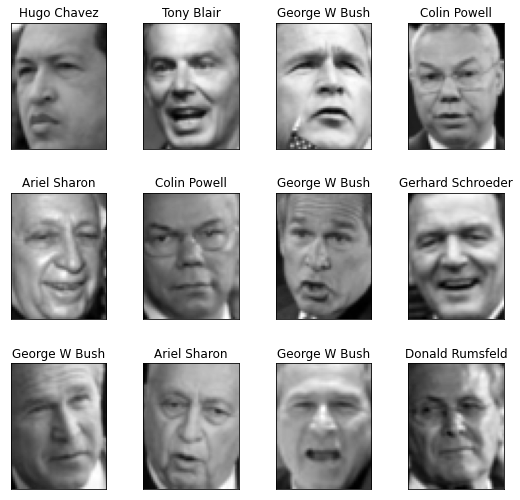

In [4]:
titles = [title(y[i], target_names) for i in range(20)]
plot_gallery(X, 12 , titles, h, w)

In [5]:
#Features: numeros reales, entre 0 y 255
print(X[0])

[[253.66667  254.33333  253.66667  ...  56.333332  46.666668  39.      ]
 [254.       254.       253.       ...  58.        48.333332  40.666668]
 [250.       247.       243.33333  ...  56.666668  48.333332  42.333332]
 ...
 [ 73.333336  58.        39.666668 ...  94.333336  91.333336  86.666664]
 [ 65.666664  51.666668  37.333332 ...  90.666664  90.333336  85.333336]
 [ 60.        50.        37.666668 ...  87.        88.        86.666664]]


## Preparación de los datos

En primer lugar, se separan los imágenes en los conjuntos de entrenamiento y de testeo (validación). Para esto, se utiliza la función **train_test_split()** de la librería sklearn.

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 14, shuffle = True)

Después, se normalizan el valor de intensidad de los píxeles de las imágenes, tanto del conjunto de entrenamiento como del de testeo. Para esto, se pasan los valores a tipo float32 y se lo divide por el valor máximo de la escala de grises de 8 bits, que es 255.

In [7]:
x_train = x_train.astype('float32') / 255.0 
x_test = x_test.astype('float32') / 255.0

Luego, realizamos la categorización de las etiquetas del conjunto de entrenamiento y de testeo. 

In [8]:
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes) #one-hot encoding

Por último, se agrega un nuevo eje para representar el canal de una imagen en escala de grises.

In [9]:
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

Ahora, se analizan los shapes de los cuatro conjuntos (imágenes y etiquetas; entrenamiento y testeo).

In [10]:
print("Shape de x_train: ", x_train.shape)
print("Shape de y_train: ", y_train.shape)
print("\nShape de x_test: ", x_test.shape)
print("Shape de y_test: ", y_test.shape)

Shape de x_train:  (1030, 62, 47, 1)
Shape de y_train:  (1030, 7)

Shape de x_test:  (258, 62, 47, 1)
Shape de y_test:  (258, 7)


Se observa que hay 1030 imágenes de entrenamiento, cada una de 62x47 píxeles y en escala de grises de 8 bits. Cada una de estas imágenes presenta su correspondiente etiqueta, la cual indica a qué clase pertenece la imagen del total de 7 clases del problema.

Por otro lado, hay 258 imágenes de testeo o validación, cada una de 62x47 píxeles y en escala de grises de 8 bits. Como en el conjunto de entrenamiento, cada imagen de testeo cuenta con su correspondiente etiqueta.

## Modelo de redes neuronales

Dado que el problema a resolver es clasificar imágenes complejas (rostros), se decide implementar un modelo de redes neuronales convolucionales. Esto se debe a que estos modelos presentan, por lo general, mejores resultados en comparación con los modelos de redes densas vistos en clase. Esto es así porque las redes convolucionales estan diseñadas para trabajar en dos dimensiones, como las imágenes, y están inspiradas en la visión del humano. 

Un modelo de redes convolucionales está compuesto por un núcleo convolucional, en donde se encuentran los kernels y capas de pooling, y una parte final (top de la red) que consiste en capas densas. La primera parte es la encargada de extraer características de las imágenes, mientras que la segunda parte es la encargada de resolver el problema de clasificación, usando las características extraídas.

### Parámetros de entrenamiento

Primero, se definen algunos parámetros a utilizar en el modelo. Estos son los siguientes:

*   **Learning rate.** Es la tasa a la cual una red neuronal aprende en cada paso de backpropagation. Define si los ajustes en cada backpropagation son pequeños o grandes.
*   **Épocas.** Es la cantidad de veces que pasaron todos los ejemplos por la red en el entrenamiento.
*   **Batch size.** Es el tamaño del batch, que es un grupo de datos que pasa por la red entre pasos de backpropagation.
*   **Random seed.** Es la semilla para generar de manera pseudoaleatoria los números aleatorios necesitados para la red. De esta manera, podemos comparar diferentes corridas del modelo, sin que la inicialización aleatoria nos afecte en los resultados.



In [11]:
lr = 1.0
epochs = 25
batch_size = 16
np.random.seed(14)  # El mismo que se usó en la división de conjunto de entrenamiento y testeo

### Arquitectura del modelo

Como se mencionó anteriormente, se construirá un modelo de redes neuronales convolucionales. Esta arquitectura tendrá las siguientes capas:

*   **Capa de entrada.** Contará con las neuronas de entrada al modelo. Se define al instanciar la clase Input. Como argumento se le pasa las dimensiones de un ejemplo.
*   **Capas convolucionales.** Son las capas que contienen los kernels, los cuales van a extraer características de las imágenes. Se definen al instanciar la clase Conv2D. Como argumentos recibe la cantidad de kernels, las dimensiones de los kernels y la función de activación.
*   **Capa de pooling**. Son capas que disminuyen la complejidad de la red y el costo computacional. se define al instanciar la clase MaxPooling2D. Como argumento recibe la dimensión de la ventana utilizada al recorrer la imagen para tomar el valor más alto en cada ventana.
*   **Capas de dropout.** Son capas que cortan de manera aleatoria algunas conexiones entre capas. Se usan para reducir el overfitting y la complejidad de la red en el entrenamiento. Se define al instanciar la clase Dropout. Como argumento recibe la tasa de desconexiones.
*   **Capa de flatten.** Esta capa "aplasta" las dimensiones de la red. Es necesaria esta capa dado que el núcleo convolucional trabaja en 2D (3 si se cuenta la profundida), mientras que las capas densas trabajan en 1 dimensión. Se define al instanciar la clase Flatten. No recibe argumentos.
*   **capas densas.** Son las capas utilizadas en el top de esta arquitectura. Son capas totalmente conexas, es decir, que todos los elementos de una capa están totalmente conectados con las neuronas de la siguiente capa. Se definen al instanciar la clase Dense. Como argumento reciben la cantidad de neuronas y la función de activación.
*   **Capa de salida.** Es una capa densa que cuenta con tantas neuronas como clases tenga el problema (7 en este caso). Como función de activación se utiliza la función softmax, que devuelve valores entre 0 y 1 para cada clase. La suma de los 7 valores para un ejemplo suman 1, por lo que estos valores se pueden interpretar como la probabilidad de que cada ejemplo pertenezca a tal clase.



In [12]:
# Model
#---------------------------------------------------------------------#
input_layer = Input(shape=x_train.shape[1:])
conv_1 = Conv2D(32, (3, 3), activation='relu') (input_layer)
conv_2 = Conv2D(64, (3, 3), activation='relu') (conv_1)
conv_3 = Conv2D(128, (3, 3), activation='relu') (conv_2)
pool_1 = MaxPooling2D(pool_size=(3, 3)) (conv_3)
dropout_1 = Dropout(0.40) (pool_1)
flatten_1 = Flatten() (dropout_1)
dense_1 = Dense(200, activation='relu') (flatten_1)
dropout_2 = Dropout(0.35) (dense_1)
dense_2 = Dense(200, activation='relu') (dropout_2)
dropout_3 = Dropout(0.35) (dense_2)
output_layer = Dense(n_classes, activation='softmax') (dropout_3)
#---------------------------------------------------------------------#
model_conv = Model(input_layer, output_layer)

Se utilizará como optimizador un Adadelta. Además, la función de costo será categorical_crossentropy y las métricas serán el Accuracy y el MSE.

In [13]:
Adadelta_optimizer = Adadelta(learning_rate=lr, rho=0.90)
model_conv.compile(optimizer=Adadelta_optimizer, loss='categorical_crossentropy', metrics=['acc', 'mse'])
model_conv.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 62, 47, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 60, 45, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 43, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 41, 128)       73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 18, 13, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 18, 13, 128)       0         
                                                             

## Entrenamiento del modelo

En esta sección, se realiza el entrenamiento del modelo planteado. Para evaluar el modelo, se utilizan las métricas Accuracy y MSE.

In [14]:
start_time = time.time()
history_conv = model_conv.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), shuffle=True, verbose=1)
end_time = time.time()
print('\nElapsed Dense Model training time: {:.5f} seconds'.format(end_time-start_time))

Epoch 1/25
65/65 [==============================] - 58s 832ms/step - loss: 1.7687 - acc: 0.4155 - mse: 0.1133 - val_loss: 1.7391 - val_acc: 0.3566 - val_mse: 0.1120
Epoch 2/25
65/65 [==============================] - 40s 619ms/step - loss: 1.6782 - acc: 0.4252 - mse: 0.1078 - val_loss: 1.6899 - val_acc: 0.3566 - val_mse: 0.1088
Epoch 3/25
65/65 [==============================] - 40s 608ms/step - loss: 1.4852 - acc: 0.4466 - mse: 0.0952 - val_loss: 1.6244 - val_acc: 0.5000 - val_mse: 0.1046
Epoch 4/25
65/65 [==============================] - 47s 719ms/step - loss: 1.2371 - acc: 0.5466 - mse: 0.0806 - val_loss: 1.2128 - val_acc: 0.5969 - val_mse: 0.0781
Epoch 5/25
65/65 [==============================] - 40s 615ms/step - loss: 0.9946 - acc: 0.6485 - mse: 0.0655 - val_loss: 0.9172 - val_acc: 0.6512 - val_mse: 0.0601
Epoch 6/25
65/65 [==============================] - 42s 640ms/step - loss: 0.7763 - acc: 0.7291 - mse: 0.0520 - val_loss: 0.9895 - val_acc: 0.6667 - val_mse: 0.0641
Epoch 7/25

In [15]:
history_conv.history.keys()

dict_keys(['loss', 'acc', 'mse', 'val_loss', 'val_acc', 'val_mse'])

## Evaluación del modelo

Ahora, se evaluará el modelo con diferentes métricas para saber qué tan bueno es para resolver el problema en cuestión.

En primer lugar, se grafican las dos métricas indicadas anteriormente, el Accuracy y el MSE, tanto para el conjunto de entrenamiento como para el de testeo.

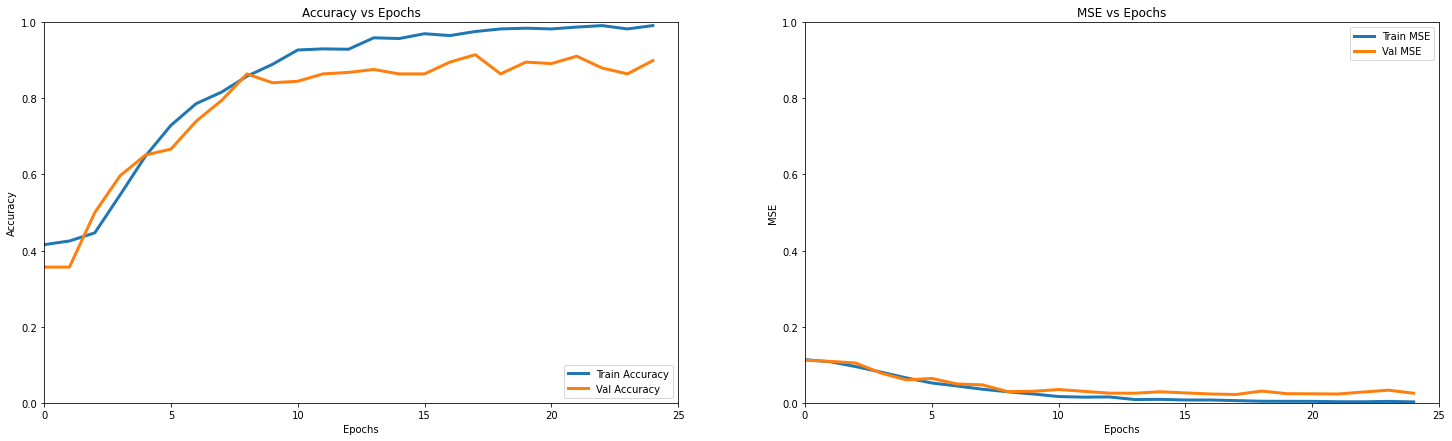

In [20]:
f = plt.figure(figsize=(25,7))

plt.subplot(1,2,1)
plt.plot(history_conv.history['acc'], linewidth=3, label='Train Accuracy')
plt.plot(history_conv.history['val_acc'], linewidth=3, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.axis([0, 25, 0, 1])
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history_conv.history['mse'], linewidth=3, label='Train MSE')
plt.plot(history_conv.history['val_mse'], linewidth=3, label='Val MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('MSE vs Epochs')
plt.axis([0, 25, 0, 1])
plt.legend(loc='upper right')

plt.show()

En los gráficos se observan la evolución de las dos métricas mencionadas a lo largo de las épocas del entrenamiento. Se observa que ambas métricas son mejores (Accuracy alto y MSE bajo) para el conjunto de entrenamiento, lo cual es coherente dado que la red utiliza estas imágenes para aprender, es decir, la red se ajusta a las imágenes de entrenamiento. El conjunto de validación nunca lo ve durante el entrenamiento.

En ambas métricas se observa una diferencia o espacio entre entrenamiento y validación. Esto se debe al overfitting, que es un sobreajuste de la red a los datos de entrenamiento. Hay varias maneras de disminuir este efecto, como por ejemplo utilizar capas de dropout y pooling.

A continuación, se realiza la matriz de confusión, la cual permite ver de manera sencilla los verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos.

In [17]:
y_pred = model_conv.predict(x_test, verbose=1)
y_true = np.argmax(y_test, axis=1) 
y_model = np.argmax(y_pred, axis=1)
CM = confusion_matrix(y_true, y_model)

target_names_list=target_names.tolist() # Se pasa a lista las etiquetas

9/9 [==============================] - 2s 250ms/step


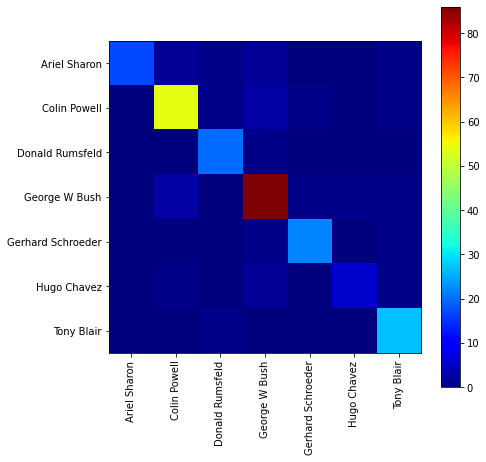

In [18]:
f = plt.figure(figsize=(7,7))
plt.imshow(CM, cmap='jet')
plt.xticks(np.arange(7), target_names_list,rotation=90)  # Set text labels and properties.
plt.yticks(np.arange(7), target_names_list,rotation=0)  # Set text labels and properties.
plt.colorbar()
plt.show()

En la matriz de confusión se puede observar que la mayoría de las imágenes se clasifican de manera correcta, las cuales se pueden visualizar en la diagonal de la matriz. Cuanto más cálido es el color (para este heatmap), más imágenes caen en cada celda. Las celdas que se encuentran afuera de la diagonal corresponden a imágenes que no se clasificaron correctamente.

## Guardado de los pesos del modelo final

A continuación, se guardan los pesos como un archivo .h5. 

In [19]:
model_conv.save('E:/Cursos/Redes neuronales desde cero - UTN/TP_final/modelo_final.h5')

## Conclusión y discusión

Como parte del proceso, se evaluaron algunas arquitecturas y se modificaron varios parámetros. Con respecto a la arquitectura, se fueron agregando capas convolucionales, capas densas y capas de drpout, y se fue evaluando las métricas para ver cual era la mejor. Después, se procedió a modificar algunos parámetros, como la cantidad de épocas, cantidad de neuronas en las redes, tasa de dropout, tamaño de la ventana de pooling, entre otros. 

Luego de probar varias combinaciones, se logró obtener un modelo de redes convolucionales con un alto valor de Accuracy (0.9913 / 0.8992) y un bajo valor de MSE (0.0024 / 0.0252), tanto para el entrenamiento como para la validación (respectivamente). La performance del modelo también se analizó con una matriz de confusión, la cual mostró que la mayoría de las imágenes se clasificaron correctamente.

Como mejoras al modelo, se podría realizar una validación cruzada para obtener varios modelos con entrenamientos diferentes y así poder sacar algunas métricas promedio. Sin embargo, esto requiere mayor poder computacional, dado que hay que entrenar varios modelos con distintos sets de entrenamiento.

Adicionalmente, se podría aplicar la técnica de aumentación de datos para aumentar la cantidad de ejemplos del dataset. Esto podría ser una buena idea, ya que el dataset total cuenta con 1288 imágenes, lo cual puede ser poco para una red neuronal.

Finalmente, el modelo obtuvo métricas superiores al 0.89, por lo que se podría decir que el problema se pudo resolver con buena precisión y bajo error.